In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from time import time
from contextlib import contextmanager
from tqdm import tqdm
import lightgbm as lgbm

In [55]:
class Timer:
    """
    with構文で使用するタイマー
    
    使用例:
        with Timer(prefix="処理時間:"):
            実行する処理
    """
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):
        if prefix:
            format_str = str(prefix) + sep + format_str
        if suffix:
            format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start_time = None
        self.end_time = None

    @property
    def duration(self):
        if self.end_time is None:
            return 0
        return self.end_time - self.start_time

    def __enter__(self):
        self.start_time = time()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end_time = time()
        output_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(output_str)
        else:
            print(output_str)

# ---------------------------
# 特徴量作成用関数
# ---------------------------
def create_numeric_features(input_df):
    """
    数値特徴量を抽出する関数（今回は全ての特徴量をそのまま利用）
    
    Parameters:
        input_df (pd.DataFrame): 入力のDataFrame
        
    Returns:
        pd.DataFrame: 数値特徴量のDataFrame
    """
    return input_df[feature_columns].copy()

def generate_features(input_df):
    """
    複数の前処理関数を適用して特徴量を作成する関数
    
    Parameters:
        input_df (pd.DataFrame): 入力のDataFrame
        
    Returns:
        pd.DataFrame: 作成された特徴量のDataFrame
    """
    processing_functions = [create_numeric_features]
    combined_features = pd.DataFrame()
    
    for function in tqdm(processing_functions, total=len(processing_functions)):
        with Timer(prefix='create ' + function.__name__):
            features_part = function(input_df)
        assert len(features_part) == len(input_df), f"{function.__name__} で行数が一致しません"
        combined_features = pd.concat([combined_features, features_part], axis=1)
    return combined_features

# ---------------------------
#  LightGBMによるモデル学習・評価関数
# ---------------------------
def train_lgbm_model(features, target, cv_splits, params: dict = None, verbose: int = 50):
    """
    LightGBMモデルの学習と交差検証の実施
    
    Parameters:
        features (np.ndarray): 特徴量
        target (np.ndarray): 目的変数
        cv_splits (list): 交差検証の分割リスト
        params (dict): LightGBMのパラメータ
        verbose (int): 学習中の詳細表示レベル
        
    Returns:
        tuple: (全体のout-of-fold予測, 学習済みモデルのリスト)
    """
    if params is None:
        params = {}

    model_list = []
    oof_predictions = np.zeros_like(target, dtype=np.float64)

    for fold_idx, (train_idx, valid_idx) in enumerate(cv_splits):
        X_train, y_train = features[train_idx], target[train_idx]
        X_valid, y_valid = features[valid_idx], target[valid_idx]

        model = lgbm.LGBMRegressor(**params)
        with Timer(prefix=f'fit fold={fold_idx}'):
            model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                # early_stopping_rounds=100, 
                verbose=verbose
            )

        fold_predictions = model.predict(X_valid)
        oof_predictions[valid_idx] = fold_predictions
        model_list.append(model)
        fold_rmsle = mean_squared_error(y_valid, fold_predictions) ** 0.5
        print(f'Fold {fold_idx} RMSLE: {fold_rmsle:.4f}\n')

    total_rmsle = mean_squared_error(target, oof_predictions) ** 0.5
    print('-' * 50)
    print(f'FINISHED | Whole RMSLE: {total_rmsle:.4f}')
    return oof_predictions, model_list


In [2]:
data1 = pd.read_csv("../data/1986-1992_race_result.csv")
data2 = pd.read_csv("../data/1993-1999_race_result.csv")
data3 = pd.read_csv("../data/2000-2005_race_result.csv")
data4 = pd.read_csv("../data/2006-2009_race_result.csv")
data5 = pd.read_csv("../data/2010-2013_race_result.csv")
data = pd.concat([data1, data2, data3, data4, data5])

C:\Users\ykanbe\AppData\Local\Temp\ipykernel_11768\404422921.py:1: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,34,36,40) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv("../data/1986-1992_race_result.csv")
C:\Users\ykanbe\AppData\Local\Temp\ipykernel_11768\404422921.py:2: DtypeWarning: Columns (8,15,16,17,18,22,25,26,27,34,36,40) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv("../data/1993-1999_race_result.csv")
C:\Users\ykanbe\AppData\Local\Temp\ipykernel_11768\404422921.py:3: DtypeWarning: Columns (11,15,16,18,22,23,25,34,36,40) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv("../data/2000-2005_race_result.csv")
C:\Users\ykanbe\AppData\Local\Temp\ipykernel_11768\404422921.py:4: DtypeWarning: Columns (11,16,18,22,23,34,36,40) have mixed types. Specify dtype option on import or set low_memory=False.
  data4 = pd.read_csv("../data/2006

In [23]:
# 発送前にわかっている情報のみ特徴量を絞る
feature_columns = [
    'Race PP ID', 'Race ID', 'Race Day', 'Race Meeting Number',
    'Racecourse Code', 'Racecourse Name', 'N-th Racing Day',
    'Race Condition','Race Number', 'Race Name',
    'Listed and Graded Races', 'Steeplechase Category',
    'Turf and Dirt Category', 'Turf and Dirt Category2',
    'Clockwise, Anti-clockwise and Straight Course Category',
    'Inner Circle, Outer Circle and Tasuki Course Category', 'Distance(m)',
    'Weather', 'Track Condition1', 'Post Time',
    'FP Note', 'Bracket Number', 'Post Position', 'Horse Name', 'Sex',
    'Age', 'Weight(Kg)', 'Jockey', 'Margin',
    'Win Odds(100Yen)', 'Win Fav', 'Horse Weight',
    'Horse Weight Gain and Loss',
    'East, West, Foreign Country and Local Category', 'Trainer', 'Owner',
]
# 着順を予測
target_column = "Final Position"

In [3]:
# 読み込んだデータの元の列名を確認
original_columns = data.columns.tolist()
print("元の列名:", original_columns)
print("列数:", len(original_columns))

元の列名: ['レース馬番ID', 'レースID', 'レース日付', '開催回数', '競馬場コード', '競馬場名', '開催日数', '競争条件', 'レース記号/[抽]', 'レース記号/(馬齢)', 'レース記号/牝', 'レース記号/(父)', 'レース記号/(別定)', 'レース記号/(混)', 'レース記号/(ハンデ)', 'レース記号/(抽)', 'レース記号/(市)', 'レース記号/(定量)', 'レース記号/牡', 'レース記号/関東配布馬', 'レース記号/(指)', 'レース記号/関西配布馬', 'レース記号/九州産馬', 'レース記号/見習騎手', 'レース記号/せん', 'レース記号/(国際)', 'レース記号/[指]', 'レース記号/(特指)', 'レース番号', '重賞回次', 'レース名', 'リステッド・重賞競走', '障害区分', '芝・ダート区分', '芝・ダート区分2', '右左回り・直線区分', '内・外・襷区分', '距離(m)', '天候', '馬場状態1', '馬場状態2', '発走時刻', '着順', '着順注記', '枠番', '馬番', '馬名', '性別', '馬齢', '斤量', '騎手', 'タイム', '着差', '1コーナー', '2コーナー', '3コーナー', '4コーナー', '上り', '単勝', '人気', '馬体重', '場体重増減', '東西・外国・地方区分', '調教師', '馬主', '賞金(万円)', 'year']
列数: 67


In [4]:
new_columns = [
    'Race PP ID', 'Race ID', 'Race Day', 'Race Meeting Number', 'Racecourse Code', 'Racecourse Name', 
    'N-th Racing Day', 'Race Condition', 'Race Symbol/Drawing', 'Race Symbol/Age', 'Race Symbol/Mare', 
    'Race Symbol/Sire', 'Race Symbol/Special Weight', 'Race Symbol/Mixed', 'Race Symbol/Handicap', 
    'Race Symbol/Drawing2', 'Race Symbol/Market', 'Race Symbol/Fixed Weight', 'Race Symbol/Stallion', 
    'Race Symbol/Kanto Distributed Horses', 'Race Symbol/Specified', 'Race Symbol/Kasai Distributed Horses', 
    'Race Symbol/Horses from Kyushu', 'Race Symbol/Apprentice', 'Race Symbol/Gelding', 'Race Symbol/International', 
    'Race Symbol/Specified2', 'Race Symbol/Special Specified', 'Race Number', 'Graded Races N-th Time', 
    'Race Name', 'Listed and Graded Races', 'Steeplechase Category', 'Turf and Dirt Category', 
    'Turf and Dirt Category2', 'Clockwise, Anti-clockwise and Straight Course Category', 
    'Inner Circle, Outer Circle and Tasuki Course Category', 'Distance(m)', 'Weather', 'Track Condition1', 
    'Track Condition2', 'Post Time', 'Final Position', 'FP Note', 'Bracket Number', 'Post Position', 
    'Horse Name', 'Sex', 'Age', 'Weight(Kg)', 'Jockey', 'Total Time(1/10s)', 'Margin', 
    'Position 1st Corner', 'Position 2nd Corner', 'Position 3rd Corner', 'Position 4th Corner', 
    'Time of Last 3 Furlongs (600m)', 'Win Odds(100Yen)', 'Win Fav', 'Horse Weight', 
    'Horse Weight Gain and Loss', 'East, West, Foreign Country and Local Category', 'Trainer', 
    'Owner', 'Prize Money(10000Yen)', 'year'
]
print("新しい列名:", new_columns)
print("列数:", len(new_columns))
# 列名を新しいものに変更
data.columns = new_columns

新しい列名: ['Race PP ID', 'Race ID', 'Race Day', 'Race Meeting Number', 'Racecourse Code', 'Racecourse Name', 'N-th Racing Day', 'Race Condition', 'Race Symbol/Drawing', 'Race Symbol/Age', 'Race Symbol/Mare', 'Race Symbol/Sire', 'Race Symbol/Special Weight', 'Race Symbol/Mixed', 'Race Symbol/Handicap', 'Race Symbol/Drawing2', 'Race Symbol/Market', 'Race Symbol/Fixed Weight', 'Race Symbol/Stallion', 'Race Symbol/Kanto Distributed Horses', 'Race Symbol/Specified', 'Race Symbol/Kasai Distributed Horses', 'Race Symbol/Horses from Kyushu', 'Race Symbol/Apprentice', 'Race Symbol/Gelding', 'Race Symbol/International', 'Race Symbol/Specified2', 'Race Symbol/Special Specified', 'Race Number', 'Graded Races N-th Time', 'Race Name', 'Listed and Graded Races', 'Steeplechase Category', 'Turf and Dirt Category', 'Turf and Dirt Category2', 'Clockwise, Anti-clockwise and Straight Course Category', 'Inner Circle, Outer Circle and Tasuki Course Category', 'Distance(m)', 'Weather', 'Track Condition1', 'Track

In [44]:
# target_columnに欠損がない行のみ抽出
non_null_indices = data[target_column].dropna(axis=0).index.tolist()
filtered_df = data.iloc[non_null_indices]

# 各列の型を確認し、object型の場合は欠損値を'N'で補完し、LabelEncoderで数値変換
processed_df = filtered_df.copy()
for column in processed_df.columns:
    print(f"{column}: {processed_df[column].dtype}")
    if processed_df[column].dtype == 'object':
        processed_df[column] = processed_df[column].fillna('N')
        label_encoder = LabelEncoder()
        processed_df[column] = label_encoder.fit_transform(processed_df[column].values)

Race PP ID: int64
Race ID: int64
Race Day: object
Race Meeting Number: int64
Racecourse Code: int64
Racecourse Name: object
N-th Racing Day: int64
Race Condition: object
Race Symbol/Drawing: object
Race Symbol/Age: object
Race Symbol/Mare: object
Race Symbol/Sire: object
Race Symbol/Special Weight: object
Race Symbol/Mixed: object
Race Symbol/Handicap: object
Race Symbol/Drawing2: object
Race Symbol/Market: object
Race Symbol/Fixed Weight: object
Race Symbol/Stallion: object
Race Symbol/Kanto Distributed Horses: object
Race Symbol/Specified: object
Race Symbol/Kasai Distributed Horses: object
Race Symbol/Horses from Kyushu: object
Race Symbol/Apprentice: object
Race Symbol/Gelding: object
Race Symbol/International: object
Race Symbol/Specified2: object
Race Symbol/Special Specified: object
Race Number: int64
Graded Races N-th Time: float64
Race Name: object
Listed and Graded Races: object
Steeplechase Category: object
Turf and Dirt Category: object
Turf and Dirt Category2: object
Clock

In [45]:
print(len(processed_df))
processed_df = processed_df.dropna(axis=0)
print(len(processed_df))


1198896
9276


In [46]:
features_df = processed_df[feature_columns]
target_series = processed_df[target_column]

In [49]:
# 特徴量の生成
train_features_df = generate_features(processed_df)

  0%|          | 0/1 [00:00<?, ?it/s]

create create_numeric_features 0.002[s]


100%|██████████| 1/1 [00:00<00:00, 250.50it/s]


In [50]:
pd.set_option('display.max_columns', 50)
for col in train_features_df.columns:
    print(col, len(train_features_df[train_features_df[col].isnull()]))

Race PP ID 0
Race ID 0
Race Day 0
Race Meeting Number 0
Racecourse Code 0
Racecourse Name 0
N-th Racing Day 0
Race Condition 0
Race Number 0
Race Name 0
Listed and Graded Races 0
Steeplechase Category 0
Turf and Dirt Category 0
Turf and Dirt Category2 0
Clockwise, Anti-clockwise and Straight Course Category 0
Inner Circle, Outer Circle and Tasuki Course Category 0
Distance(m) 0
Weather 0
Track Condition1 0
Post Time 0
FP Note 0
Bracket Number 0
Post Position 0
Horse Name 0
Sex 0
Age 0
Weight(Kg) 0
Jockey 0
Margin 0
Win Odds(100Yen) 0
Win Fav 0
Horse Weight 0
Horse Weight Gain and Loss 0
East, West, Foreign Country and Local Category 0
Trainer 0
Owner 0


[100]	valid_0's l2: 0.343351
fit fold=0 0.116[s]
Fold 0 RMSLE: 0.5860

[100]	valid_0's l2: 0.320608
fit fold=1 0.103[s]
Fold 1 RMSLE: 0.5662

[100]	valid_0's l2: 0.345554
fit fold=2 0.103[s]
Fold 2 RMSLE: 0.5878

[100]	valid_0's l2: 0.308387
fit fold=3 0.096[s]
Fold 3 RMSLE: 0.5553

[100]	valid_0's l2: 0.331653
fit fold=4 0.096[s]
Fold 4 RMSLE: 0.5759

--------------------------------------------------
FINISHED | Whole RMSLE: 0.5744


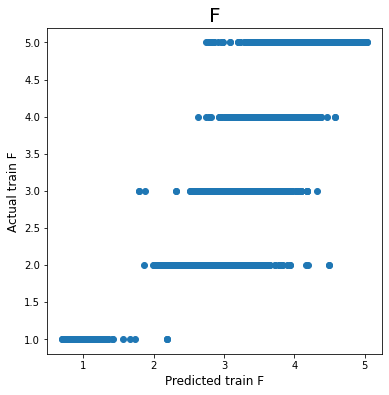

In [56]:
# ---------------------------
# モデル学習の実行
# ---------------------------
# KFoldによる交差検証の設定
kf = KFold(n_splits=5, shuffle=True, random_state=71)
target_array = np.array(target_series)
cv_indices = list(kf.split(train_features_df, target_array))

# LightGBMのパラメータ（必要に応じて変更）
lgbm_params = {}

# モデルの学習を実行
oof_preds, trained_models = train_lgbm_model(train_features_df.values, target_array, cv_indices, params=lgbm_params, verbose=100)

# 予測値と実際の目的変数との散布図をプロット
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(target_column[0], fontsize=20)
ax.set_xlabel('Predicted train ' + target_column[0], fontsize=12)
ax.set_ylabel('Actual train ' + target_column[0], fontsize=12)
ax.scatter(oof_preds, target_array)
plt.show()